In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:

appName = "ClimateEventsApp"
master = 'local'

# Create Spark session
spark = SparkSession.builder \
    .master(master) \
    .appName(appName) \
    .getOrCreate()

In [3]:
schema = StructType() \
      .add("Date",DateType(),True) \
      .add("MaxT",FloatType(),True) \
      .add("MinT",FloatType(),True) \
      .add("AvgT",FloatType(),True) \
      .add("MaxWind",FloatType(),True) \
      .add("AvgWind",FloatType(),True) \
      .add("MaxRain",FloatType(),True) \
      .add("MinRain",FloatType(),True) \
      .add("AvgRain",FloatType(),True) \
      .add("MaxHU",FloatType(),True) \
      .add("MinHU",FloatType(),True) \
      .add("AvgHU",FloatType(),True) 



In [4]:
df = spark.read.format("csv") \
      .option("header", True) \
      .option("delimiter", "|") \
      .schema(schema) \
      .load("./DFCLEAN.csv") 

In [5]:
df.show()


+----------+---------+----------+---------+----------+---------+-------+-------+-----------+-----+-----+---------+
|      Date|     MaxT|      MinT|     AvgT|   MaxWind|  AvgWind|MaxRain|MinRain|    AvgRain|MaxHU|MinHU|    AvgHU|
+----------+---------+----------+---------+----------+---------+-------+-------+-----------+-----+-----+---------+
|1997-06-02|20.325027| 10.485029|16.139194| 6.5693827|4.7183585|    0.7|    0.0| 0.09583334|100.0| 54.0|75.541664|
|1997-06-03|19.215029| 12.685029|16.641695|  6.130579|2.9472077|    0.5|    0.0|0.108333334|100.0| 66.0|80.666664|
|1997-06-04|22.655027| 12.945029|18.063362|10.1376915|5.2097836|    0.0|    0.0|        0.0| 90.0| 52.0|70.041664|
|1997-06-05|24.735027| 10.945029|17.930862| 18.847641| 8.095111|    1.2|    0.0| 0.23333333| 96.0| 53.0|     82.0|
|1997-06-06|24.775028| 12.545029|19.456696|  8.287822| 4.428185|    0.0|    0.0|        0.0|100.0| 50.0|     73.5|
|1997-06-07|28.705029| 13.335029|22.337946|  6.792466|5.5862846|    0.4|    0.0|

In [6]:
df = df.withColumn("Year",F.year("Date")).withColumn("Month",F.month("Date")).orderBy("Date")

In [7]:
df.show()

+----------+----------+----------+------------+---------+----------+-------+-------+-----------+-----+-----+---------+----+-----+
|      Date|      MaxT|      MinT|        AvgT|  MaxWind|   AvgWind|MaxRain|MinRain|    AvgRain|MaxHU|MinHU|    AvgHU|Year|Month|
+----------+----------+----------+------------+---------+----------+-------+-------+-----------+-----+-----+---------+----+-----+
|1985-01-01|0.64502877|-2.3549712|-0.027471205|41.556225| 30.392813|    0.9|    0.0| 0.45833334| 98.0| 86.0|   94.375|1985|    1|
|1985-01-02|0.64502877|-1.5349712| -0.24413788|41.556225| 24.185526|    0.9|    0.1|      0.425| 98.0| 91.0|95.041664|1985|    1|
|1985-01-03|-1.7049713|-3.4449713|  -2.5933046|28.019936| 15.353347|    0.2|    0.0| 0.07083333| 94.0| 83.0|89.541664|1985|    1|
|1985-01-04|-0.9549713|-15.234971|  -6.0420547|  28.1169|15.0967245|    1.3|    0.0| 0.59166664|100.0| 71.0|92.541664|1985|    1|
|1985-01-05| -8.394971|-17.884972|  -12.125388| 9.449572| 6.2888417|    0.0|    0.0|      

In [8]:
df_stat_per_year = df.groupBy("Year")\
    .agg(sum("AvgRain").alias("SumRain") ,\
     avg("AvgRain").alias("AvgAvgRain") ,\
    max("MaxRain").alias("MaxRain") ,\
    max("MaxT").alias("MaxT") ,\
    avg("MaxT").alias("AvgMaxT") ,\
    avg("AvgT").alias("AvgAvgT") ,\
).orderBy("Year")
        

In [9]:
df_stat_per_year.show(40)


+----+------------------+--------------------+-------+---------+------------------+------------------+
|Year|           SumRain|          AvgAvgRain|MaxRain|     MaxT|           AvgMaxT|           AvgAvgT|
+----+------------------+--------------------+-------+---------+------------------+------------------+
|1985| 34.62083367165178| 0.09485159910041584|    4.2|31.355028|14.207658711361558|  9.55091459311749|
|1986|  45.2583338660188| 0.12399543524936658|    4.4|35.685028|14.308151804910947| 9.980645167189714|
|1987| 43.68750056019053| 0.11969178235668639|    5.1| 37.26503| 14.01878198156618|  9.85694535715531|
|1988|   43.725000415463| 0.11946721424989891|    5.6|35.075027|15.262378288422777| 10.90444920568274|
|1989|28.720833533909172| 0.07868721516139499|    4.5| 32.22503|16.147631306517614|11.300879134870556|
|1990| 38.07916685845703| 0.10432648454371789|    3.7|33.505028|16.090096953797016|11.484969366607192|
|1991| 32.61666698940098| 0.08936073147781091|    4.8|35.325027|15.597768

In [10]:
df_stat_per_month = df.groupBy("Year", "Month")\
    .agg(sum("AvgRain").alias("SumRain") ,\
     avg("AvgRain").alias("AvgAvgRain") ,\
    max("MaxRain").alias("MaxRain") ,\
    max("MaxT").alias("MaxT") ,\
    avg("MaxT").alias("AvgMaxT") ,\
    avg("AvgT").alias("AvgAvgT") ,\
).orderBy("Year", "Month")

In [11]:
df_stat_per_month.show()

+----+-----+------------------+-------------------+-------+---------+--------------------+-------------------+
|Year|Month|           SumRain|         AvgAvgRain|MaxRain|     MaxT|             AvgMaxT|            AvgAvgT|
+----+-----+------------------+-------------------+-------+---------+--------------------+-------------------+
|1985|    1|4.6250000493600965|0.14919354997935794|    3.5|10.555029| 0.09115787090793732|-2.5296620315000897|
|1985|    2|1.9583333535119891|0.06994047691114247|    2.0|16.225029|   5.658243132489068| 1.5449097859007972|
|1985|    3| 2.416666724719107| 0.0779569911199712|    1.3|16.785028|   9.057609661932915|   5.07410143844543|
|1985|    4| 4.545833355747163|0.15152777852490545|    4.2|26.675028|  14.137361971537272|  9.049751035372417|
|1985|    5| 5.062500077765435|0.16330645412146563|    2.2|27.025028|  17.671480086541944| 12.539813733869984|
|1985|    6|2.9000000432133675|0.09666666810711225|    2.2|27.035028|  19.390028285980225| 13.996237150828044|
|

In [12]:
# Year|           SumRain|          AvgAvgRain|MaxRain|     MaxT|           AvgMaxT|           AvgAvgT|
data = df_stat_per_year.select("Year","SumRain", "AvgAvgRain","MaxRain", "MaxT", "AvgMaxT", "AvgAvgT" ).collect()
x = [i.Year for i in data]
y_rain_sum = [i.SumRain for i in data]
y_AvgAvgRain = [i.AvgAvgRain for i in data]
y_MaxRain = [i.MaxRain for i in data]
y_MaxT = [i.MaxT for i in data]
y_AvgMaxT = [i.AvgMaxT for i in data]
y_AvgAvgT = [i.AvgAvgT for i in data]


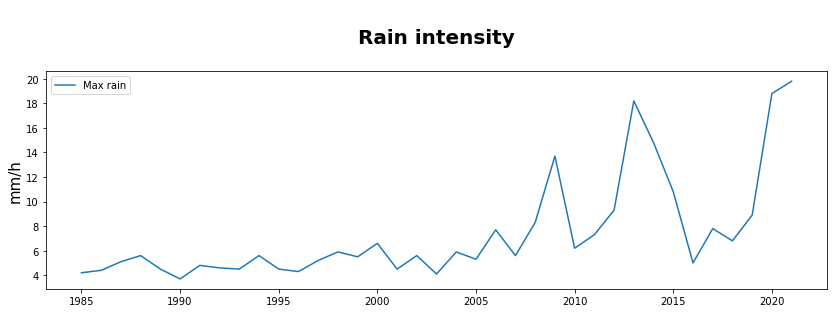

In [13]:
plt.figure(figsize=(14,4))
#plt.plot(x, y_AvgAvgRain, label="Average rain")
plt.plot(x, y_MaxRain, label="Max rain")
plt.ylabel(r'mm/h', fontsize=15)

plt.title('\nRain intensity\n', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

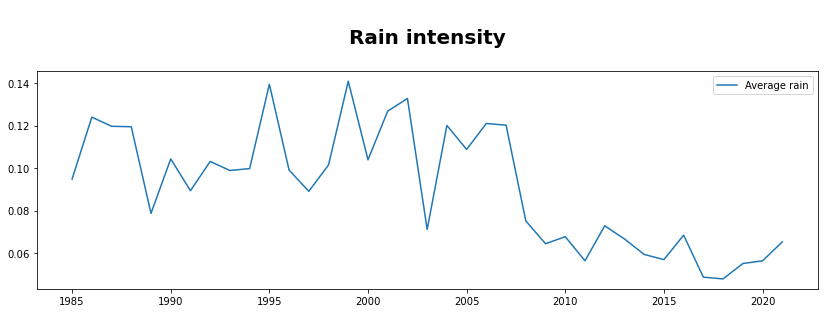

In [14]:
plt.figure(figsize=(14,4))
plt.plot(x, y_AvgAvgRain, label="Average rain")
#plt.plot(x, y_MaxRain, label="Max rain")

plt.title('\nRain intensity\n', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

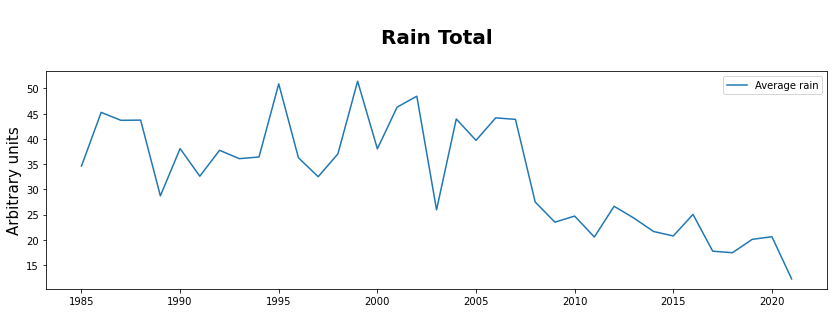

In [15]:
plt.figure(figsize=(14,4))
plt.plot(x, y_rain_sum, label="Average rain")
plt.ylabel(r'Arbitrary units', fontsize=15)
plt.title('\nRain Total\n', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

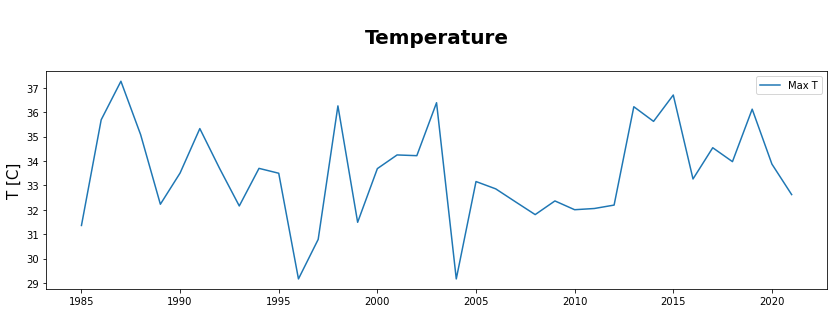

In [16]:
plt.figure(figsize=(14,4))
plt.plot(x, y_MaxT, label="Max T")


plt.ylabel(r'T [C]', fontsize=15)
plt.title('\nTemperature\n', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

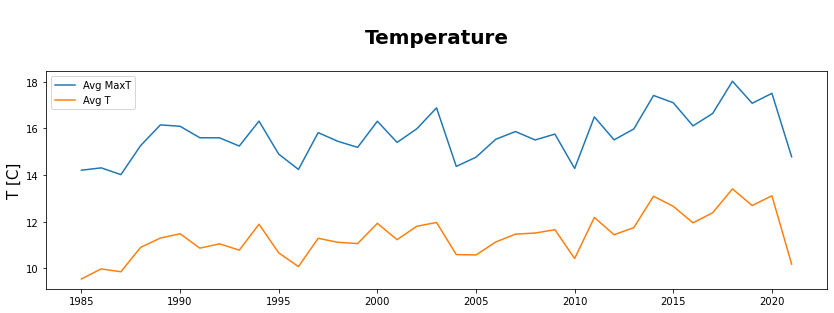

In [17]:
plt.figure(figsize=(14,4))
plt.plot(x, y_AvgMaxT, label="Avg MaxT")
plt.plot(x, y_AvgAvgT, label="Avg T")

plt.ylabel(r'T [C]', fontsize=15)
plt.title('\nTemperature\n', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

What we are in particular interested is the occurence of violent climatic events, such as storms, or hot waves.
In our datasets this means counting the occurence of daily events as:
* Daily temperature above 30 Celsius
* Rain above 2 mm/h

In [18]:
def is_day_extreme(max_T, max_rain):
    if (max_T>30 or max_rain >2):
        return 1.0
    else:
        return 0.0

In [19]:
udf_func = udf(lambda maxT, maxRain: is_day_extreme(maxT, maxRain), returnType=FloatType())

df = df.withColumn('ExtremeDay', udf_func(df.MaxT, df.MaxRain))

In [20]:
df.show()

+----------+----------+----------+------------+---------+----------+-------+-------+-----------+-----+-----+---------+----+-----+----------+
|      Date|      MaxT|      MinT|        AvgT|  MaxWind|   AvgWind|MaxRain|MinRain|    AvgRain|MaxHU|MinHU|    AvgHU|Year|Month|ExtremeDay|
+----------+----------+----------+------------+---------+----------+-------+-------+-----------+-----+-----+---------+----+-----+----------+
|1985-01-01|0.64502877|-2.3549712|-0.027471205|41.556225| 30.392813|    0.9|    0.0| 0.45833334| 98.0| 86.0|   94.375|1985|    1|       0.0|
|1985-01-02|0.64502877|-1.5349712| -0.24413788|41.556225| 24.185526|    0.9|    0.1|      0.425| 98.0| 91.0|95.041664|1985|    1|       0.0|
|1985-01-03|-1.7049713|-3.4449713|  -2.5933046|28.019936| 15.353347|    0.2|    0.0| 0.07083333| 94.0| 83.0|89.541664|1985|    1|       0.0|
|1985-01-04|-0.9549713|-15.234971|  -6.0420547|  28.1169|15.0967245|    1.3|    0.0| 0.59166664|100.0| 71.0|92.541664|1985|    1|       0.0|
|1985-01-05| 

In [21]:
data = df.groupBy("Year").agg(sum("ExtremeDay").alias("ExtremeDay")).orderBy("Year").select("Year","ExtremeDay" ).collect()
x = [i.Year for i in data]
y_ExtremeDay = [i.ExtremeDay for i in data]

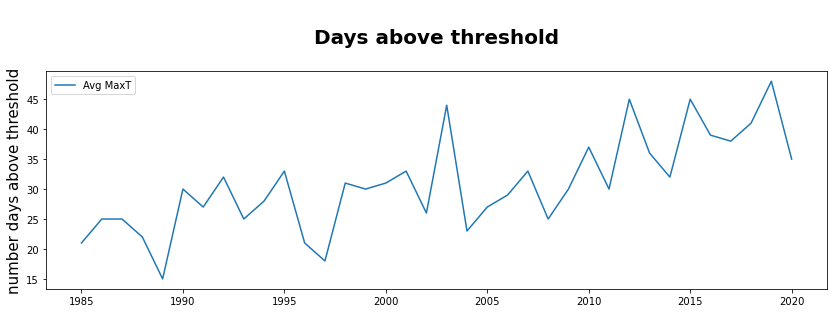

In [22]:
plt.figure(figsize=(14,4))
plt.plot(x[:-1], y_ExtremeDay[:-1], label="Avg MaxT")


plt.ylabel(r'number days above threshold', fontsize=15)
plt.title('\nDays above threshold\n', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

As evident from the picture, the number of difficult days increased of almost a factor two, wrt the 1984

In [23]:
#df.write.format('csv').option('header',True).mode('overwrite').option('sep','|').save('./DFCLEAN_Eng.csv')